In [1]:
%matplotlib inline

In [2]:
import logging
import time
import traceback
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials, space_eval

import nengo
from nengo.solvers import LstsqL2

nengo.rc.set('progress', 'progress_bar', 'none')
nengo.rc.set('decoder_cache', 'enabled', 'False')

import nengolib
from nengolib.networks import EchoState, RollingWindow, readout

print("nengo=={:}".format(nengo.__version__))
print("nengolib=={:}".format(nengolib.__version__))

nengo==2.5.0
nengolib==0.4.1-dev


In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = 'cm'

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

c:\Users\Aaron\Anaconda2\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


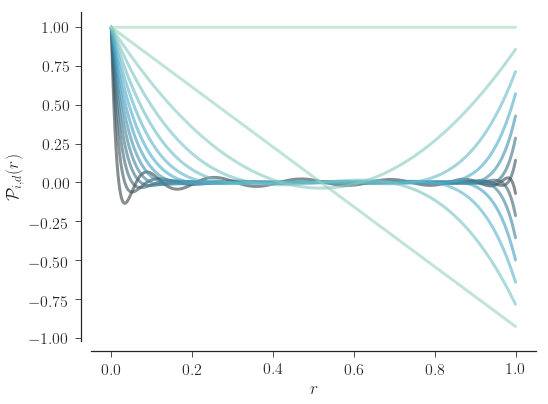

In [4]:
t = np.linspace(0, 1, 2000)
B = np.asarray([readout(q=14, r=r) for r in t])

with sns.axes_style('ticks'):
    with sns.plotting_context('paper', font_scale=2):
        plt.figure(figsize=(8, 6))
        for b, c in zip(B.T, sns.color_palette("GnBu_d", B.shape[1])):
            plt.plot(t, b, c=c, lw=3, alpha=0.6)
        plt.xlabel(r"$r$")
        plt.ylabel(r"$\mathcal{P}_{i, d}(r)$")
        sns.despine(offset=10)
        plt.savefig("basis.pdf", dpi=600)
        plt.show()

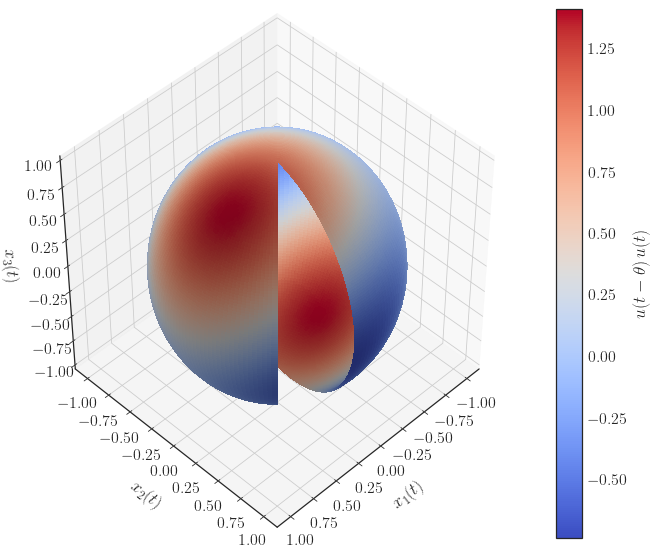

In [5]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


def visualize_3dfunction(f, faces,
                         time_points=1000,
                         orthogonal_basis=False,
                         cmap=cm.coolwarm,
                         cutaway=0,
                         offset=0,
                         rotate=1./4,
                         fname=None,
                         **kwargs):
    offset += rotate
    u = np.linspace((cutaway + offset)*np.pi,
                    (2 + offset - cutaway)*np.pi,
                    int(np.sqrt(faces)))
    v = np.linspace(0, np.pi, int(np.sqrt(faces)))
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v)) 
    Z = np.outer(np.ones(np.size(u)), np.cos(v))
    
    t = np.linspace(0, 1, time_points)
    B = np.asarray([readout(3, r) for r in t])

    if orthogonal_basis:
        B, _, _ = svd(B, full_matrices=False)

    W = (B[:, 0]*X[:, :, None] +
         B[:, 1]*Y[:, :, None] +
         B[:, 2]*Z[:, :, None])
    C = np.apply_along_axis(f, 2, W)
    
    nC = C.copy()
    nC -= np.min(nC)
    nC /= np.max(nC)
    assert np.allclose(np.max(nC), 1)
    
    with sns.axes_style('white'):
        with sns.plotting_context('paper', font_scale=2):
            fig = plt.figure(figsize=(9.5, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_surface(X, Y, Z, facecolors=cmap(nC),
                            linewidth=1, cstride=1, rstride=1,
                            antialiased=False)
            ax.view_init(elev=45, azim=180*rotate)

            ax.set_xlabel("$x_1(t)$", labelpad=18)
            ax.set_ylabel("$x_2(t)$", labelpad=18)
            ax.set_zlabel("$x_3(t)$", labelpad=18)

            m = cm.ScalarMappable(cmap=cmap)
            m.set_array(C)
            plt.colorbar(m, fraction=0.046, pad=0.04, label=r"$u(t - \theta) \, u(t)$")

            if fname is not None:
                plt.savefig(fname, **kwargs)
            plt.show()


visualize_3dfunction(lambda w: w[0]*w[-1],
                     faces=25000, time_points=2,
                     cutaway=0.1, offset=0.1,
                     fname="autocorrelation.pdf", dpi=600)

In [6]:
def next_seed(rng):
    return rng.randint(1 << 30)


def progress_bar(steps, task):
    from nengo.utils.progress import ProgressTracker, AutoProgressBar, TerminalProgressBar
    # manually pass in progress_bar since otherwise uses nengo's rc setting
    return ProgressTracker(steps, AutoProgressBar(TerminalProgressBar(None)), task)


class DelayMethod(object):
    """Abstract network method to be tested on a delay function."""

    def __init__(self, theta, n_neurons, function, t_init, t_train, t_test,
                 tau_compare, process, dt, train_rng):
        self.theta = theta
        self.n_neurons = n_neurons
        self.function = function
        self.t_init = t_init
        self.t_train = t_train
        self.t_test = t_test
        self.tau_compare = tau_compare
        self.process = process
        self.dt = dt
        self.train_rng = train_rng
        
    def hyperopt(self, num_trials, max_evals):
        task = type(self).__name__
        bar = progress_bar(num_trials * max_evals, task)
        assert bar.progress_bar.progress_bar.task == task

        def objective(kwargs, bar=bar, best_loss=[np.inf]):  # Hack: mutable
            logging.info("[Handling: %s]", kwargs)

            times = []
            losses = []
            raw_data = []
            analyses = []
            for _ in range(num_trials):
                # Simulation (training and testing)
                start = time.time()
                try:
                    args = self.go(**kwargs)
                except KeyboardInterrupt:
                    raise
                except:
                    warnings.warn(
                        "Call to %{:}.go(**{:}) failed; continuing".format(
                            task, repr(kwargs)))
                    return {
                        'status': STATUS_FAIL,
                        'attachments': {
                            'traceback': traceback.format_exc()
                        }
                    }
                times.append(time.time() - start)

                # Analysis
                analysis = self.analyze(*args)
                losses.append(analysis['loss'])
                raw_data.append(args)
                analyses.append(analysis)

                bar.step()

            loss = np.mean(losses)
            if loss < best_loss[0]:
                best_loss[0] = loss
                bar.progress_bar.progress_bar.task = (
                    "{:} - Best Loss: {:.3f}".format(task, loss))
            loss_variance = np.var(losses)

            return {
                'loss': loss,
                'loss_variance': loss_variance,
                'status': STATUS_OK,
                'attachments': {
                    'times': times,
                    'losses': losses,
                    'raw_data': raw_data,
                    'analyses': analyses,
                }
            }

        trials = Trials()
        with bar:
            best = fmin(
                objective, space=self.space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)
        return best, np.min(trials.losses()), trials

    def analyze(self, t, data_in, data_out):
        probe = nengolib.Lowpass(self.tau_compare)
        ideal = self.function(data_in)
        offset = int(self.t_init / self.dt)
        # Note: Filter after removing the transient in case it includes
        # a large start-up (as it often does for ESNs)
        actual = probe.filt(data_out.squeeze()[offset:], dt=self.dt)
        target = probe.filt(ideal.squeeze()[offset:], dt=self.dt)
        loss = nengolib.signal.nrmse(actual=actual, target=target)
        return {
            'loss': loss,
            't_valid': t[offset:],
            'actual': actual,
            'target': target
        }

    def go(self, *args, **kwargs):
        # should return (t, data_in, data_out) unless
        # the analyze method is overridden
        raise NotImplementedError("Method must be derived by children")
    
    def go_best(self, best):
        return self.go(**space_eval(self.space, best))

    def next_seed(self):
        return next_seed(self.train_rng)


class ESN(DelayMethod):
    """Echo-state network implementing the given function."""

    neuron_type = nengolib.neurons.Tanh()

    @property
    def space(self):
        return {
            'recurrent_synapse': hp.uniform('recurrent_synapse', 0.001, 0.01),
            'readout_synapse': hp.uniform('readout_synapse', 0.001, 0.1),
            'radii': hp.uniform('radii', 15, 30),
            'gain': hp.uniform('gain', 0.75, 1.5),
            'reg': hp.loguniform('reg', np.log(1e-6), np.log(1e-1)),
            'include_bias': hp.choice('include_bias', [False, True]),
        }

    def go(self, recurrent_synapse, readout_synapse, radii, gain, reg, include_bias):
        # Creation
        model = EchoState(
            self.n_neurons, 1, recurrent_synapse=recurrent_synapse,
            readout_synapse=readout_synapse, radii=radii, gain=gain,
            neuron_type=self.neuron_type, include_bias=include_bias,
            rng=self.train_rng, ens_seed=self.next_seed())

        # Training
        model.train(
            self.function, self.t_train, self.dt, self.process,
            t_init=self.t_init, solver=LstsqL2(reg=reg),
            seed=self.next_seed())

        sim, (data_in, _, data_out) = model.run(
            self.t_test, self.dt, self.process, seed=self.next_seed())
        return sim.trange(), data_in, data_out
    

class IdealAutoCorrelation(DelayMethod):
    """Implementation of autocorrelation assuming ideal PadeDelay and multiplier."""
    
    @property
    def space(self):
        return {
            'q': hp.quniform('q', 14, 23, 1),
        }
    
    def go(self, q):
        q = int(q)
        sys = nengolib.synapses.PadeDelay(theta=self.theta, order=q)
        u = self.process.run(self.t_test, dt=self.dt, rng=self.train_rng).squeeze()
        t = self.process.trange(self.t_test, dt=self.dt)    
        x = sys.X.filt(u, dt=self.dt)
        return t, u, x.dot(readout(q, 0)) * x.dot(readout(q, 1))


class Direct(DelayMethod):
    """Direct mode implementation of delay network autocorrelation."""
    
    neuron_type = nengo.Direct()

    @property
    def space(self):
        return {
            'q': hp.quniform('q', 14, 23, 1),
            'realizer': hp.choice('realizer', [nengolib.signal.Hankel(),
                                               nengolib.signal.Balanced(),
                                               nengolib.signal.Identity()]),
            'synapse': hp.uniform('synapse', 0.05, 1.0),
            'p_diag': hp.uniform('p_diag', 0, 1),
            'recurrent_reg': hp.loguniform('recurrent_reg', np.log(1e-5), np.log(1e-1)),
            'readout_reg': hp.loguniform('readout_reg', np.log(1e-5), np.log(1e-1)),
        }
    
    def go(self, q, realizer, synapse, p_diag, recurrent_reg, readout_reg):
        q = int(q)
        
        # TODO: there needs to be an easier way to do the below
        sample_u = self.process.run(self.t_train, dt=self.dt, rng=self.train_rng).squeeze()
        realizer_result = realizer(nengolib.synapses.PadeDelay(self.theta, order=q))
        eval_points = realizer_result.realization.X.filt(sample_u, dt=self.dt)
        radii = np.max(np.abs(eval_points), axis=0)
        assert radii.shape == (q,)
    
        # Pick a proportion of the encoders to be diagonal with respect to the
        # vectors that decode u(t-theta) and u(t)
        # Note the diagonal encoders are scaled according to the radius of u
        # and assuming [u(t-theta), u(t)] is a circle (not a square)
        diag = np.asarray([[1, 1], [1, -1], [-1, 1], [-1, -1]]).dot([
            readout(q, 0).dot(realizer_result.T),
            readout(q, 1).dot(realizer_result.T)]) * np.max(np.abs(sample_u)) / np.sqrt(2)
        num_diag = int(p_diag*self.n_neurons)
        encoders = np.empty((self.n_neurons, q))
        encoders[:num_diag, :] = nengo.dists.Choice(diag).sample(num_diag)
        encoders[num_diag:, :] = nengo.dists.Choice(
            np.vstack([np.eye(q), -np.eye(q)])).sample(self.n_neurons - num_diag)
        
        with RollingWindow(theta=self.theta,
                           n_neurons=self.n_neurons,
                           process=None,
                           radii=radii,
                           encoders=encoders,
                           normalize_encoders=False,
                           eval_points=eval_points/radii,
                           dimensions=q,
                           dt=self.dt,
                           realizer=realizer,
                           neuron_type=self.neuron_type,
                           input_synapse=synapse,
                           synapse=synapse,
                           seed=self.next_seed(),
                           solver=LstsqL2(reg=recurrent_reg)) as model:
            stim = nengo.Node(output=self.process)
            nengo.Connection(stim, model.input, synapse=None)
            output = model.add_output(
                [0, 1], lambda w: w[0]*w[1], synapse=None,
                solver=LstsqL2(reg=readout_reg))
            p_stim = nengo.Probe(stim, synapse=None)
            p_output = nengo.Probe(output, synapse=None)
        
        with nengo.Simulator(model, dt=self.dt, seed=self.next_seed()) as sim:
            sim.run(self.t_test)
        
        return sim.trange(), sim.data[p_stim], sim.data[p_output]
    

class Sigmoid(Direct):
    """Sigmoid (rate) neuron implementation of delay network autocorrelation."""
    
    neuron_type = nengo.Sigmoid()


class SpikingLIF(Direct):   
    """Spiking LIF neuron implementation of delay network autocorrelation."""

    neuron_type = nengo.LIF()

In [7]:
from nengo.processes import WhiteSignal
from nengolib.signal import shift

# Note: This is global so that the factory produces a different
# network each time it is invoked. This is to prevent hyperopt
# from finding a network that is simply lucky in its random weights
# as opposed to one that has ideal hyperparameters.
train_rng = np.random.RandomState(seed=0)


def factory(delay_method, train_rng=train_rng):
    theta = 0.1
    hz = 30
    dt = 0.001
    n_neurons = 1000
    tau_compare = 0.1
    t_init = 2*theta
    t_test = 2000*dt + t_init
    t_train = 10000*dt + t_init
    process = WhiteSignal(t_train, high=hz, y0=0)

    steps = int(theta / dt)
    def autocorrelation(x, steps=steps):
        return shift(x, steps) * x

    return delay_method(
        theta=theta,
        n_neurons=n_neurons,
        function=autocorrelation,
        t_init=t_init,
        t_train=t_train,
        t_test=t_test,
        tau_compare=tau_compare,
        process=process,
        dt=dt,
        train_rng=train_rng)

In [8]:
def analyze(network, best, loss, trials):
    print(type(network).__name__, loss, space_eval(network.space, best))
    
    analysis = network.analyze(*network.go_best(best))
    
    plt.figure()
    plt.title("%s - %.3f (Cross-Validation)" % (
        type(network).__name__, analysis['loss']))
    plt.plot(analysis['t_valid'], analysis['target'])
    plt.plot(analysis['t_valid'], analysis['actual'])
    plt.show()

ESN - Best Loss: 0.729 finished in 4:56:39.                                     
('ESN', 0.72907838324451302, {'radii': 24.8664837635723, 'gain': 1.035098779113388, 'readout_synapse': 0.010617475052725592, 'recurrent_synapse': 0.005317866105612379, 'include_bias': True, 'reg': 2.623309932736252e-06})


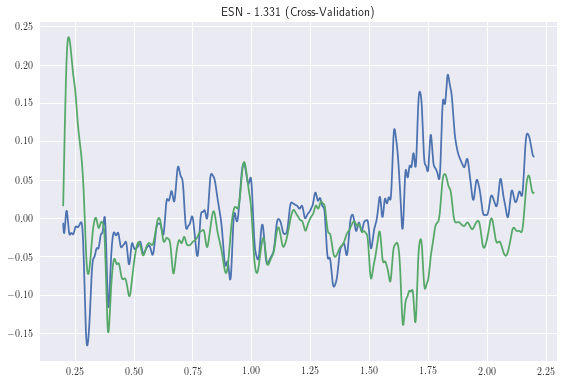

c:\users\aaron\ctn\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
c:\Users\Aaron\Anaconda2\lib\site-packages\scipy\signal\filter_design.py:1057: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
c:\Users\Aaron\Anaconda2\lib\site-packages\nengo\neurons.py:293: RuntimeWarning: overflow encountered in exp
  output[...] = (1. / self.tau_ref) / (1.0 + np.exp(-J))


Sigmoid - Best Loss: 0.054 finished in 1:26:33.                                 
('Sigmoid', 0.053887762816079113, {'recurrent_reg': 0.000850298830475625, 'q': 19.0, 'synapse': 0.4478020008831704, 'p_diag': 0.10473930853823132, 'realizer': Balanced(), 'readout_reg': 0.002347813296140026})


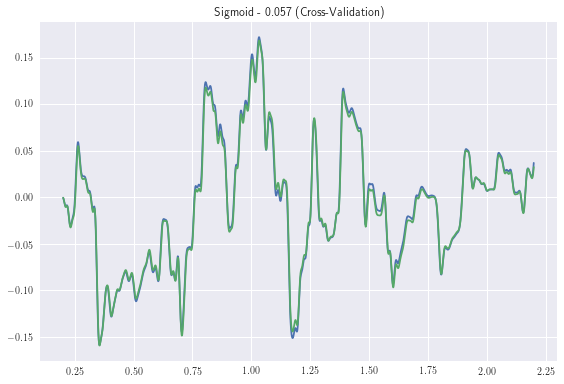

SpikingLIF - Best Loss: 0.471 finished in 1:48:49.                              
('SpikingLIF', 0.47119716847168835, {'recurrent_reg': 0.02769553100318941, 'q': 21.0, 'synapse': 0.2556261050865516, 'p_diag': 0.08229855654215312, 'realizer': Balanced(), 'readout_reg': 0.03059220197767896})


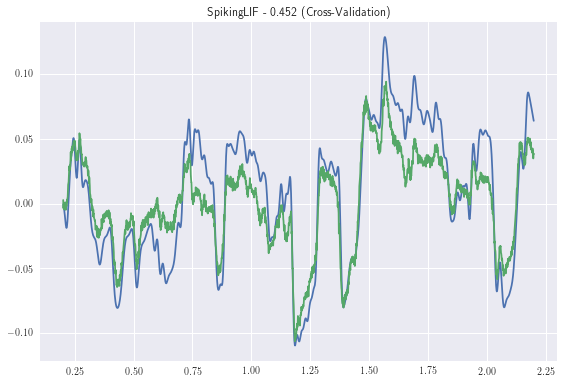

IdealAutoCorrelation - Best Loss: 0.029 finished in 0:01:41.                    
('IdealAutoCorrelation', 0.028954302508560549, {'q': 16.0})


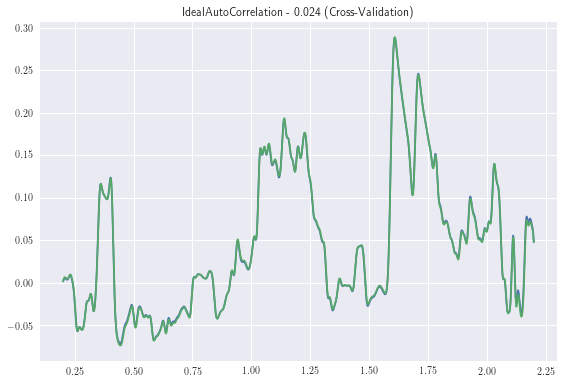

Direct - Best Loss: 0.027 finished in 0:23:15.                                  
('Direct', 0.027309801316626952, {'recurrent_reg': 0.02503095600722409, 'q': 15.0, 'synapse': 0.8838202648166724, 'p_diag': 0.1829890996654524, 'realizer': Hankel(), 'readout_reg': 0.0005518850453132356})


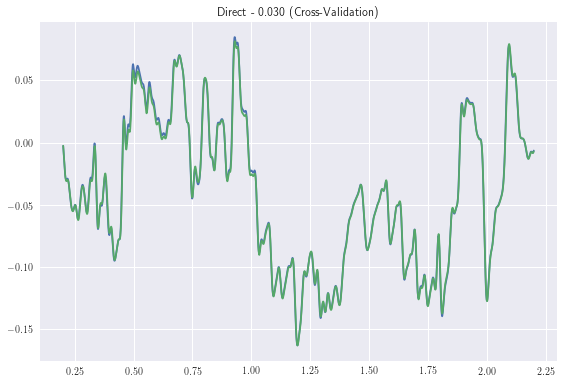

In [9]:
outputs = []
for method in [ESN, Sigmoid, SpikingLIF, IdealAutoCorrelation, Direct]:
    network = factory(method)
    args = network.hyperopt(num_trials=10, max_evals=100)
    analyze(network, *args) 
    outputs.append((network, args))

In [11]:
num_cross = 25
data = []
with progress_bar(num_cross * len(outputs), "Cross-validating") as bar:
    for network, (best, loss, trials) in outputs:
        for _ in range(num_cross):
            analysis = network.analyze(*network.go_best(best))
            data.append((type(network).__name__, analysis['loss']))
            bar.step()

Cross-validating finished in 0:12:01.                                           


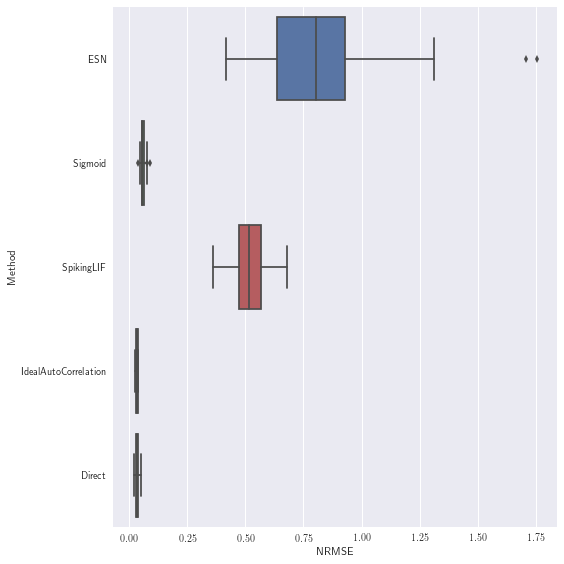

In [12]:
import pandas as pd

df = pd.DataFrame(data, columns=("Method", "NRMSE"))

plt.figure(figsize=(8, 8))
sns.boxplot(data=df, y="Method", x="NRMSE")
plt.show()

In [13]:
def bootstrap_ci(data, func, n=3000, p=0.95):
    # Author: Terry Stewart
    # Source: https://github.com/ctn-waterloo/best-practices/blob/master/Confidence%20Intervals%20-%20bootstrap.ipynb  # noqa: E501
    index = int(n*(1-p)/2)
    samples = np.random.choice(data, size=(n, len(data)))
    try:
        r = func(samples, axis=1)  # if the function supports axis
    except TypeError:
        r = [func(s) for s in samples]  # otherwise do it the slow way
    r.sort()
    return r[index], r[-index]

# Cross-validation normalized RMSE (mean and confidence intervals)
for method in np.unique(df["Method"]):
    losses = df[df["Method"] == method]["NRMSE"]
    print("{:}: NRMSE={:} [{:.3}, {:.3}]".format(
        method, np.mean(losses), *bootstrap_ci(losses, np.mean)))

Direct: NRMSE=0.0325448448687 [0.0298, 0.0355]
ESN: NRMSE=0.843849210227 [0.727, 0.982]
IdealAutoCorrelation: NRMSE=0.0313661201686 [0.0296, 0.0332]
Sigmoid: NRMSE=0.0590087044658 [0.0549, 0.0633]
SpikingLIF: NRMSE=0.518480611141 [0.484, 0.552]


In [14]:
# Trial times
for network, (best, loss, trials) in outputs:
    print("{:}: Time={:.3}s".format(
        type(network).__name__,
        np.mean([t for trial in trials.trials
                 if trial['result']['status'] != 'fail'
                 for t in trials.trial_attachments(trial)['times']])))

ESN: Time=17.7s
Sigmoid: Time=5.1s
SpikingLIF: Time=6.44s
IdealAutoCorrelation: Time=0.0395s
Direct: Time=1.29s
